In [69]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy

In [50]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
hnm_file_format = 'data/HnM_{}.parquet'
hnm_img_format = 'images/HnM/{}'

In [47]:
# folder names
hnm_img_temp = 'images/HnM/'
hnm_img_final = 'images_final/HnM/'

In [62]:
# get list of images
imgs = [k for k in os.listdir('images/HnM/')]

In [15]:
print(f"We have a total of {len(imgs):,} images")

We have a total of 16,473 images


In [63]:
img_fmt = "images/HnM/{}"

### Checking prediction with a single product - Using resnet50

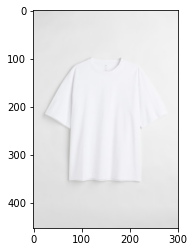

In [64]:
key = 100
img = plt.imread(img_fmt.format(imgs[key]))
plt.imshow(img)

In [65]:
base_model = ResNet50(weights='imagenet')

img_path = img_fmt.format(imgs[key])
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

Predicted: [('n03595614', 'jersey', 0.740426), ('n04370456', 'sweatshirt', 0.05712101), ('n03630383', 'lab_coat', 0.047350466)]


### Let's train a model using Resnet CNNs

In [11]:
## load the data frame
df = pd.read_parquet(hnm_file_format.format('Final_Input_Df'))

In [13]:
df.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
4,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
5,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
6,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops


In [21]:
df['Category_Name'] = df['Category_Name'].astype('category')

In [22]:
df['Category_Name_Code'] = df['Category_Name'].cat.codes

In [25]:
df[['Category_Name', 'Category_Name_Code']].drop_duplicates().sort_values(by='Category_Name_Code')

,Category_Name,Category_Name_Code
16681,Baby_Accessoires,0
15042,Baby_Kleidung,1
22239,Kids_Accessoires,2
16885,Kids_Kleidung,3
21916,Kids_Outdoor,4
22548,Kids_Schuhe,5
14065,Men_Accessoires,6
12335,Men_Cardigans-&-Pullover,7
12481,Men_Hemden,8
12120,Men_Hoodies-&-Sweatshirts,9


In [26]:
# sort by the code since thats how flow from directory would work
df = df.sort_values(by='Code')
df.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Name_Code
9842,0107727001,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9844,0107727002,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9839,0107727021,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9832,0107727061,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9837,0107727062,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23


In [37]:
y_train = df['Category_Name_Code'].values
nr_labels = len(np.unique(y_train))

In [48]:
# move all images into the final images folder

# first, move any images in the final folder to the original folder
for img in os.listdir(hnm_img_final):
    os.rename( hnm_img_final+img, hnm_img_temp+img )

# now, move the images as per the df into the target folder
for idx, row in df.iterrows():
    os.rename(hnm_img_temp + row['Code'] + row['Img_Ext'], hnm_img_final + row['Code'] + row['Img_Ext'])

In [80]:
random_seed = 109

images_train = image_dataset_from_directory(
    'images_final',
    labels = list(y_train),
    subset = 'training',
    validation_split = 0.2,
    seed = random_seed,
    image_size=(224, 224)
)

images_val = image_dataset_from_directory(
    'images_final',
    labels = list(y_train),
    subset = 'validation',
    validation_split = 0.2,
    seed = random_seed,
    image_size=(224, 224)
)


Found 14456 files belonging to 1 classes.
Using 11565 files for training.
Found 14456 files belonging to 1 classes.
Using 2891 files for validation.


In [81]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [82]:
# add a global spatial average pooling layer
# x = base_model.output
x = base_model.get_layer('avg_pool').output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(nr_labels, activation='softmax')(x)


# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# model.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(), metrics=[Accuracy])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [83]:
# train the model on the new data for a few epochs
hist = model.fit(
    images_train, 
    batch_size=32,
    epochs=1,
    validation_data=images_val,
)


 16/362 [>.............................] - ETA: 17:36 - loss: 3.3215

KeyboardInterrupt: 